# Phase 1 – Baseline Comparison Using Risk-Based Features

This notebook corresponds to Phase 1 of the experimental setup described in the thesis. It evaluates the performance of supervised and One-Class models using a predefined set of 13 variables, which were selected and categorised by domain experts according to risk levels.

The aim of this phase is to establish a baseline under the same feature conditions used by the current production model deployed in the company.

The following models are evaluated:

* **Supervised models**: Logistic Regression, Linear SVM
* **One-Class models**: One-Class SVM, Isolation Forest, Approximate Polytope Ensemble (APE)

Model performance is assessed using both ROC and Precision-Recall curves.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC, OneClassSVM, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
from scipy.spatial import ConvexHull
from collections import Counter
from joblib import dump, load
from sklearn.base import BaseEstimator

In [2]:
# Set display and visualisation options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 5)

# Load data

In [ ]:
df = pd.read_csv('', sep = ',', low_memory=False)

In [4]:
# Map target variable: B (good payer) = 0, M (defaulter) = 1
df['TARGET_VAR'] = df['TARGET_VAR'].map({'B': 0, 'M': 1})

In [5]:
# Split the dataset into train and test sets
df_train = df[df['sample'] == '01 - TRAIN']
df_test = df[df['sample'] == '01 - TEST']

# Subset of 'good payers', for One Class training
df_train_good = df_train[df_train['TARGET_VAR'] == 0]

In [6]:
X_train = df_train[['VAR1', 'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6', 'VAR7', 'VAR8', 'VAR9', 'VAR10', 'VAR11', 'VAR12', 'VAR13']]
y_train = df_train['TARGET_VAR']
X_test = df_test[['VAR1', 'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6', 'VAR7', 'VAR8', 'VAR9', 'VAR10', 'VAR11', 'VAR12', 'VAR13']]
y_test = df_test['TARGET_VAR']
X_train_good = df_train_good[['VAR1', 'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6', 'VAR7', 'VAR8', 'VAR9', 'VAR10', 'VAR11', 'VAR12', 'VAR13']]

# Preprocessing 

In [7]:
# Function to compute WoE encoding 
def calculate_woe(df, var, target):
    temp = df.groupby(var)[target].value_counts(normalize=True).unstack(fill_value=0)
    temp['woe'] = np.log(temp[1] / temp[0])  # WOE = log(P(good) / P(bad))
    return temp[['woe']]

In [8]:
# Create dictionary of WoE mappings for each feature
woe_dict = {}
for var in X_train.columns:
    woe_dict[var] = calculate_woe(df_train, var, 'TARGET_VAR')

In [9]:
# Apply WoE transformation to the training and test sets
X_train_woe = X_train.copy()
X_test_woe = X_test.copy()
X_train_good_woe = X_train_good.copy()

for var in X_train.columns:
    woe_mapping = woe_dict[var]['woe'].to_dict()
    X_train_woe[var] = X_train[var].map(woe_mapping)
    X_train_good_woe[var] = X_train_good[var].map(woe_mapping)
    X_test_woe[var] = X_test[var].map(woe_mapping)

In [10]:
# Feature scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_woe)
X_test_scaled = scaler.transform(X_test_woe)
X_train_good_scaled = scaler.transform(X_train_good_woe)

In [11]:
X_train_final_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_final_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_good_final_df = pd.DataFrame(X_train_good_scaled, columns=X_train_good.columns)

# Logistic Regression

In [12]:
# Parameters
MODEL_PATH   = "logreg_model_cat.joblib"
N_SPLITS     = 5 # Number of folds for cross validation
RANDOM_SEED  = 42

In [13]:
# K- Fold stratified
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
aucs = []
aps  = []

In [14]:
# Load existing model if available
if os.path.exists(MODEL_PATH):
    print("Loading existing model")
    logreg = load(MODEL_PATH)
else:
    print("Training model with 5 fold CV")
    # ─── 5-Fold CV ───
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final_df, y_train), start=1):
        X_tr, X_val = X_train_final_df.iloc[train_idx], X_train_final_df.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LogisticRegression(max_iter=10000, class_weight='balanced')
        model.fit(X_tr, y_tr)

        prob = model.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, prob)
        ap  = average_precision_score(y_val, prob)
        aucs.append(auc)
        aps.append(ap)

        print(f"Fold {fold}: AUC = {auc:.3f}, AP = {ap:.3f}")

    # Summary of cross validation results
    print(f"\nCV summary ({N_SPLITS} folds):")
    print(f"  Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Mean AP : {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # Final training on the full set
    logreg = LogisticRegression(max_iter=10000, class_weight='balanced')
    logreg.fit(X_train_final_df, y_train)
    dump(logreg, MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'")

Loading existing model


In [15]:
# Evaluate on the test set
y_test_proba = logreg.predict_proba(X_test_final_df)[:,1]
test_auc = roc_auc_score(y_test, y_test_proba)
test_ap  = average_precision_score(y_test, y_test_proba)

print(f"\nTest set performance:")
print(f"  AUC = {test_auc:.3f}")
print(f"  AP  = {test_ap:.3f}")


Test set performance:
  AUC = 0.772
  AP  = 0.085


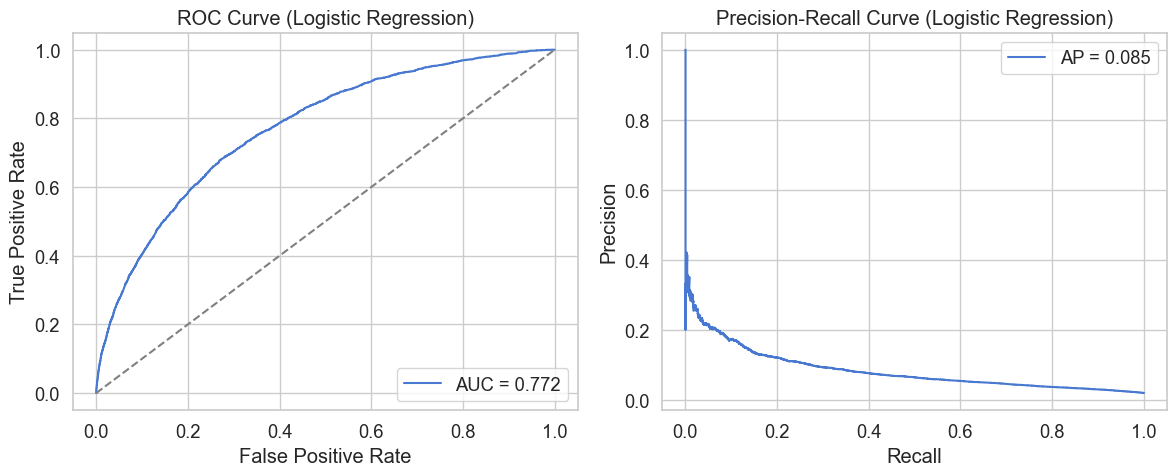

In [16]:
# Plot ROC and PR curves
fpr, tpr, _          = roc_curve(y_test, y_test_proba)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='grey')
plt.title('ROC Curve (Logistic Regression)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {test_ap:.3f}')
plt.title('Precision-Recall Curve (Logistic Regression)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Linear SVM

In [17]:
MODEL_PATH   = "linear_svc_calibrated_cat.joblib"
N_SPLITS     = 5
RANDOM_SEED  = 42
MAX_ITER = 10000

In [18]:
skf  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
aucs = []
aps  = []

In [19]:
# Load existing model if available
if os.path.exists(MODEL_PATH):
    print("Loading existing model")
    svc_calibrated = load(MODEL_PATH)
else:
    print("Training model with 5 fold CV")

    # ─── 5-Fold CV ───
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final_df, y_train), start=1):
        X_tr, X_val = X_train_final_df.iloc[train_idx], X_train_final_df.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx],           y_train.iloc[val_idx]

        # Train the base LinearSVC
        base_svc = LinearSVC(
            max_iter=MAX_ITER,
            class_weight='balanced',
            dual=False,
            random_state=RANDOM_SEED
        )
        base_svc.fit(X_tr, y_tr)

        # Calibrate probabilities on the validation fold
        calibrated = CalibratedClassifierCV(
            estimator=base_svc,
            method='sigmoid',
            cv=5
        )
        calibrated.fit(X_val, y_val)

        # Evaluate performance on the validation fold
        y_val_proba = calibrated.predict_proba(X_val)[:, 1]
        fold_auc = roc_auc_score(y_val, y_val_proba)
        fold_ap  = average_precision_score(y_val, y_val_proba)
        aucs.append(fold_auc)
        aps.append(fold_ap)

        print(f" Fold {fold}: AUC = {fold_auc:.3f}, AP = {fold_ap:.3f}")

    # Cross validation summary
    print(f"\nCV summary ({N_SPLITS} folds):")
    print(f"  Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Mean AP : {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # Final training on full train set with calibration
    base_final = LinearSVC(
        max_iter=MAX_ITER,
        class_weight='balanced',
        dual=False,
        random_state=RANDOM_SEED
    )
    base_final.fit(X_train_final_df, y_train)

    svc_calibrated = CalibratedClassifierCV(
        estimator=base_final,
        method='sigmoid',
        cv=5
    )
    svc_calibrated.fit(X_train_final_df, y_train)

    dump(svc_calibrated, MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'")

Loading existing model


In [20]:
# Evaluate on the test set
y_test_proba = svc_calibrated.predict_proba(X_test_final_df)[:, 1]
test_auc     = roc_auc_score(y_test, y_test_proba)
test_ap      = average_precision_score(y_test, y_test_proba)

print(f"\nTest set performance:")
print(f"  AUC = {test_auc:.3f}")
print(f"  AP  = {test_ap:.3f}")


Test set performance:
  AUC = 0.771
  AP  = 0.085


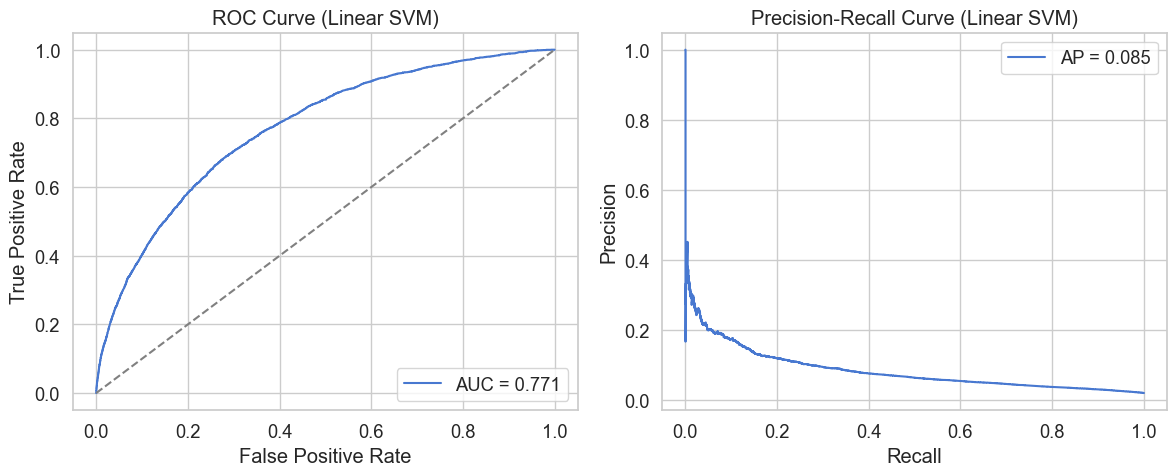

In [21]:
# Plot ROC and PR curves
fpr, tpr, _          = roc_curve(y_test, y_test_proba)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.title('ROC Curve (Linear SVM)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {test_ap:.3f}')
plt.title('Precision-Recall Curve (Linear SVM)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# One Class SVM

In [22]:
MODEL_PATH   = "oneclass_svm_cat.joblib"
N_SPLITS     = 5 
RANDOM_SEED  = 42

In [23]:
skf  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
aucs = []
aps  = []

In [24]:
# Load existing model if available
if os.path.exists(MODEL_PATH):
    print("Loading existing model")
    ocsvm = load(MODEL_PATH)
else:
    print("Training model with 5 fold CV")
    # ─── 5-Fold CV ───
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final_df, y_train), start=1):
        X_tr, X_val = X_train_final_df.iloc[train_idx], X_train_final_df.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx],           y_train.iloc[val_idx]

        # Training only with GOODS (label 0)
        mask_good   = (y_tr.values == 0)
        X_tr_good   = X_tr.iloc[mask_good] 

        ocsvm = OneClassSVM(gamma='auto', nu=0.02)
        ocsvm.fit(X_tr_good)

        # Invert score: higher score = more anomaly
        scores = -ocsvm.decision_function(X_val)
        fold_auc = roc_auc_score(y_val, scores)
        fold_ap  = average_precision_score(y_val, scores)
        aucs.append(fold_auc)
        aps.append(fold_ap)

        print(f" Fold {fold}: AUC = {fold_auc:.3f}, AP = {fold_ap:.3f}")

    # Summary of cross validation results
    print(f"\nCV summary ({N_SPLITS} folds):")
    print(f"  Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Mean AP : {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # Train final model on all available 'good' samples
    mask_all_good = (y_train.values == 0)
    X_train_good  = X_train_final_df.iloc[mask_all_good]
    ocsvm = OneClassSVM(gamma='auto', nu=0.02)
    ocsvm.fit(X_train_good)
    dump(ocsvm, MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'")

Loading existing model


In [25]:
# Evaluate on the test set
scores_test = -ocsvm.decision_function(X_test_final_df)
test_auc   = roc_auc_score(y_test, scores_test)
test_ap    = average_precision_score(y_test, scores_test)

print(f"\nTest set performance:")
print(f"  AUC = {test_auc:.3f}")
print(f"  AP  = {test_ap:.3f}")


Test set performance:
  AUC = 0.531
  AP  = 0.038


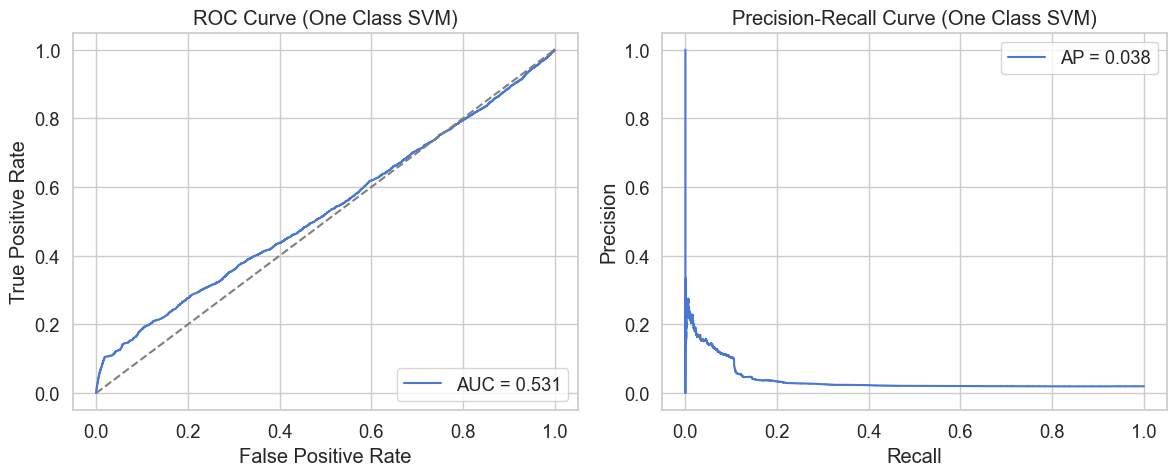

In [26]:
# Plot ROC and PR curves
fpr, tpr, _          = roc_curve(y_test, scores_test)
precision, recall, _ = precision_recall_curve(y_test, scores_test)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.title('ROC Curve (One Class SVM)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {test_ap:.3f}')
plt.title('Precision-Recall Curve (One Class SVM)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Isolation Forest

In [27]:
# Parameters
MODEL_PATH   = "isolation_forest_cat.joblib"
N_SPLITS     = 5
RANDOM_SEED  = 42
CONTAMINATION = 0.02  # expected proportion of anomalies

In [28]:
skf  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
aucs = []
aps  = []

In [29]:
# Load existing model if available
if os.path.exists(MODEL_PATH):
    print("Loading existing model")
    iso = load(MODEL_PATH)
else:
    print("Training model with 5 fold CV")
    # ─── 5-Fold CV ───
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final_df, y_train), start=1):
        X_tr, X_val = X_train_final_df.iloc[train_idx], X_train_final_df.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx],           y_train.iloc[val_idx]

        # Training only with GOODS (label 0)
        mask_good   = (y_tr.values == 0)
        X_tr_good   = X_tr.iloc[mask_good]  
        iso = IsolationForest(
            n_estimators=100,
            contamination=CONTAMINATION,
            random_state=RANDOM_SEED
        )
        iso.fit(X_tr_good)

        # Invert score: higher score = more anomaly
        scores = -iso.decision_function(X_val)
        fold_auc = roc_auc_score(y_val, scores)
        fold_ap  = average_precision_score(y_val, scores)
        aucs.append(fold_auc)
        aps.append(fold_ap)

        print(f" Fold {fold}: AUC = {fold_auc:.3f}, AP = {fold_ap:.3f}")

    # Summary of cross validation results
    print(f"\nCV summary ({N_SPLITS} folds):")
    print(f"  Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Mean AP : {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # Train final model on all available 'good' samples
    mask_all_good = (y_train.values == 0)
    X_train_good  = X_train_final_df.iloc[mask_all_good]
    iso = IsolationForest(
        n_estimators=100,
        contamination=CONTAMINATION,
        random_state=RANDOM_SEED
    )
    iso.fit(X_train_good)
    dump(iso, MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'")

Loading existing model


In [30]:
# Evaluate on the test set
scores_test = -iso.decision_function(X_test_final_df)
test_auc   = roc_auc_score(y_test, scores_test)
test_ap    = average_precision_score(y_test, scores_test)

print(f"\nTest set performance:")
print(f"  AUC = {test_auc:.3f}")
print(f"  AP  = {test_ap:.3f}")


Test set performance:
  AUC = 0.694
  AP  = 0.059


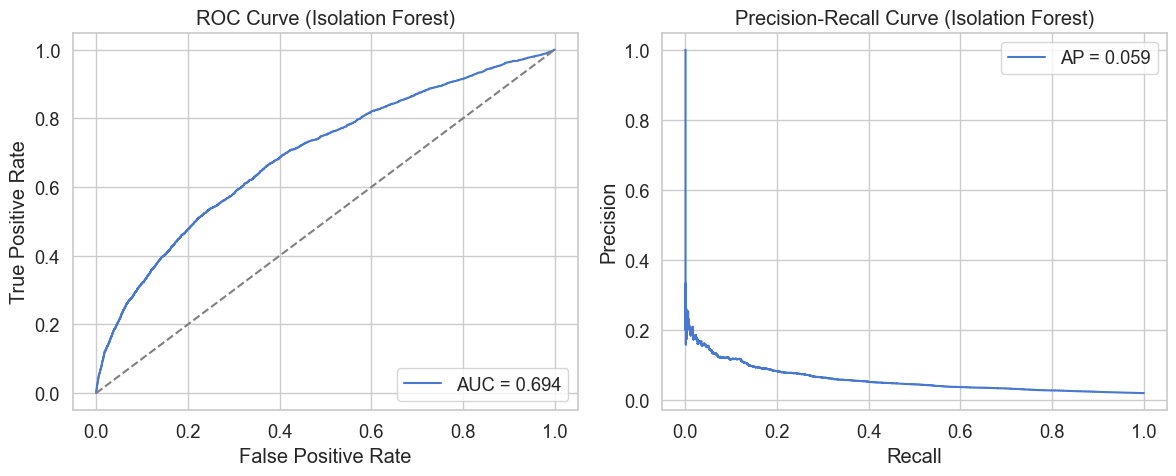

In [31]:
# Plot ROC and PR curves
fpr, tpr, _          = roc_curve(y_test, scores_test)
precision, recall, _ = precision_recall_curve(y_test, scores_test)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.title('ROC Curve (Isolation Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {test_ap:.3f}')
plt.title('Precision-Recall Curve (Isolation Forest)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Approximate Polytope Ensemble

In [32]:
# Remap labels for APE: 0 (good) = 1, 1 (bad) = -1
y_train_ape = y_train.map({0: 1, 1: -1})
y_test_ape  = y_test.map({0: 1, 1: -1})

## APE Class Definition

In [33]:
class APE_base():
    def __init__(self,**kwargs):
        self.__dict__=kwargs

class APE(BaseEstimator):
    def __init__(self, n_proj=100, target=1., frac=0.01):
        np.random.seed(0)
        self.n_proj = n_proj # Number of projections
        self.target = target # Target class for projection
        self.frac = frac # Fraction of training samples to use for each projection
        self.ape = []
        self.oape = []

    def _in_hull(self, p, hull):
        # Check if each point lies inside the convex hull
        ic = np.zeros((p.shape[0],))
        for equation in hull.equations:
            n = equation[0:2]
            o = equation[2]
            ic += np.where(np.dot(n, p.T) + o > 1e-6, 1, 0)
        return ic <= 0

    def fit(self, X, y):
        ape = []
        N = X.shape[0]
        self.ratio_outside = np.zeros(N)
        self.stats_ = {
            "seen": np.zeros(N),
            "outhull": np.zeros(N)
        }
        self.oape = []

        for t in range(self.n_proj):
            idx_subset = np.random.choice(N, size=int(self.frac * N), replace=False)
            X_subset = X.iloc[idx_subset]
            y_subset = y.iloc[idx_subset].squeeze().to_numpy()

            clf = APE_base()
            clf.P = np.random.randn(X.shape[1], 2) # Random projection matrix
            clf.P[:, 0] /= np.linalg.norm(clf.P[:, 0])            
            clf.P[:, 1] -= np.dot(clf.P[:, 1], clf.P[:, 0]) * clf.P[:, 0]
            clf.P[:, 1] /= np.linalg.norm(clf.P[:, 1])

            X_proj = np.dot(X_subset[y_subset == self.target], clf.P)
            clf.hull = ConvexHull(X_proj)
            self.oape.append(clf)

            # Save statistics in absolute indices
            X_proj_all = np.dot(X.iloc[idx_subset], clf.P)
            in_mask = self._in_hull(X_proj_all, clf.hull)
            self.stats_["seen"][idx_subset] += 1
            self.stats_["outhull"][idx_subset] += ~in_mask

        return self

    def score_samples(self, X):
        # Compute how often each sample falls outside the hulls
        ratio = np.zeros(X.shape[0])
        seen = np.zeros(X.shape[0])
        outhull = np.zeros(X.shape[0])

        for clf in self.oape:
            X_proj = np.dot(X, clf.P)
            in_mask = self._in_hull(X_proj, clf.hull)
            seen += 1
            outhull += ~in_mask

        ratio = np.divide(outhull, seen, out=np.zeros_like(outhull), where=seen > 0)
        return ratio

    def predict(self, X):
        # Predict +1 if never outside, -1 if outside at least once
        scores = self.score_samples(X)
        return np.where(scores == 0, 1., -1.)

In [34]:
# Parameters
MODEL_PATH   = "ape_cat.joblib"
N_SPLITS     = 5 
RANDOM_SEED  = 42

In [35]:
skf  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
aucs = []
aps  = []

In [36]:
# Load existing model if available
if os.path.exists(MODEL_PATH):
    print("Loading existing model")
    ape = load(MODEL_PATH)
else:
    print("Training model with 5 fold CV")
    # ─── 5-Fold CV ───
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final_df, y_train_ape), start=1):
        X_tr, X_val = X_train_final_df.iloc[train_idx], X_train_final_df.iloc[val_idx]
        y_tr, y_val = y_train_ape.iloc[train_idx], y_train_ape.iloc[val_idx]

        model = APE(n_proj=100000, frac=0.01)
        model.fit(X_tr, y_tr)

        scores = model.score_samples(X_val)
        auc = roc_auc_score(y_val, scores)
        ap  = average_precision_score(y_val, scores)
        aucs.append(auc)
        aps.append(ap)

        print(f"Fold {fold}: AUC = {auc:.3f}, AP = {ap:.3f}")

    # Cross validation summary
    print(f"\nCV summary ({N_SPLITS} folds):")
    print(f"  Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Mean AP : {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # Final training on the full set
    ape = APE(n_proj=100000, frac=0.01, target=1) 
    ape.fit(X_train_final_df, y_train_ape)
    dump(ape, MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'")

Loading existing model


In [37]:
# Evaluate on the test set
scores_test = ape.score_samples(X_test_final_df) 
fpr, tpr, _ = roc_curve(y_test_ape, scores_test, pos_label=-1)
test_auc = auc(fpr, tpr)
test_ap  = average_precision_score(y_test_ape, scores_test, pos_label=-1)

print(f"\nTest set performance:")
print(f"  AUC = {test_auc:.3f}")
print(f"  AP  = {test_ap:.3f}")


Test set performance:
  AUC = 0.660
  AP  = 0.056


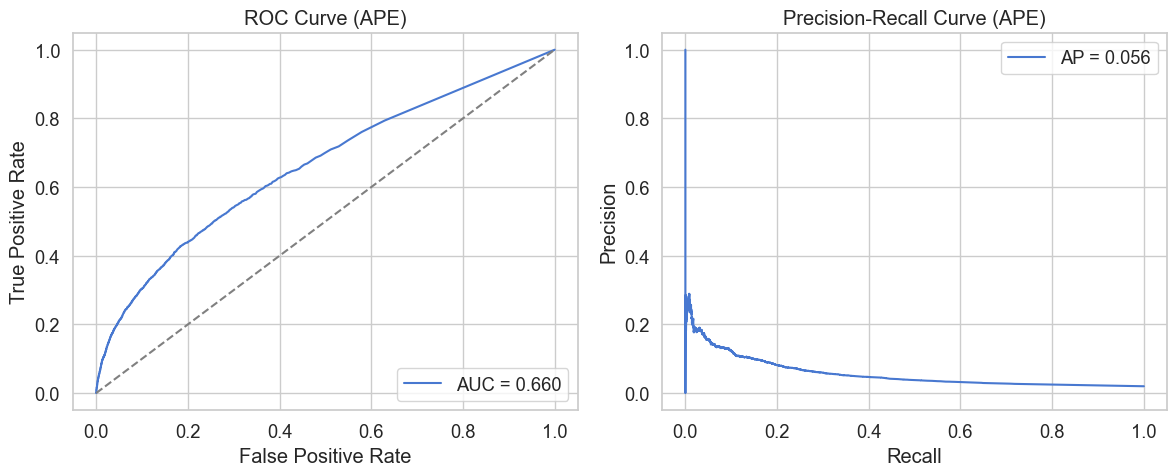

In [38]:
# Plot ROC and PR curves
fpr, tpr, _          = roc_curve(y_test_ape, scores_test, pos_label=-1)
precision, recall, _ = precision_recall_curve(y_test_ape, scores_test, pos_label=-1)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='grey')
plt.title('ROC Curve (APE)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {test_ap:.3f}')
plt.title('Precision-Recall Curve (APE)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Model Comparison on Test Set

In [39]:
# Load saved models
logreg  = load('logreg_model_cat.joblib')
svm_lin = load('linear_svc_calibrated_cat.joblib')
ocsvm   = load('oneclass_svm_cat.joblib')
iso     = load('isolation_forest_cat.joblib')
ape     = load('ape_cat.joblib')

# Dictionary of models
models = {
    'Logistic Regression': logreg,
    'Linear SVM':          svm_lin,
    'One-Class SVM':       ocsvm,
    'Isolation Forest':    iso,
    'APE':                 ape
}

In [40]:
# Compute anomaly or probability scores on test set
scores = {}

for name, model in models.items():
    if name in ['Logistic Regression', 'Linear SVM']:
        scores[name] = model.predict_proba(X_test_final_df)[:, 1]
    elif name == 'APE':
        scores[name] = model.score_samples(X_test_final_df)
    else:
        scores[name] = -model.decision_function(X_test_final_df)


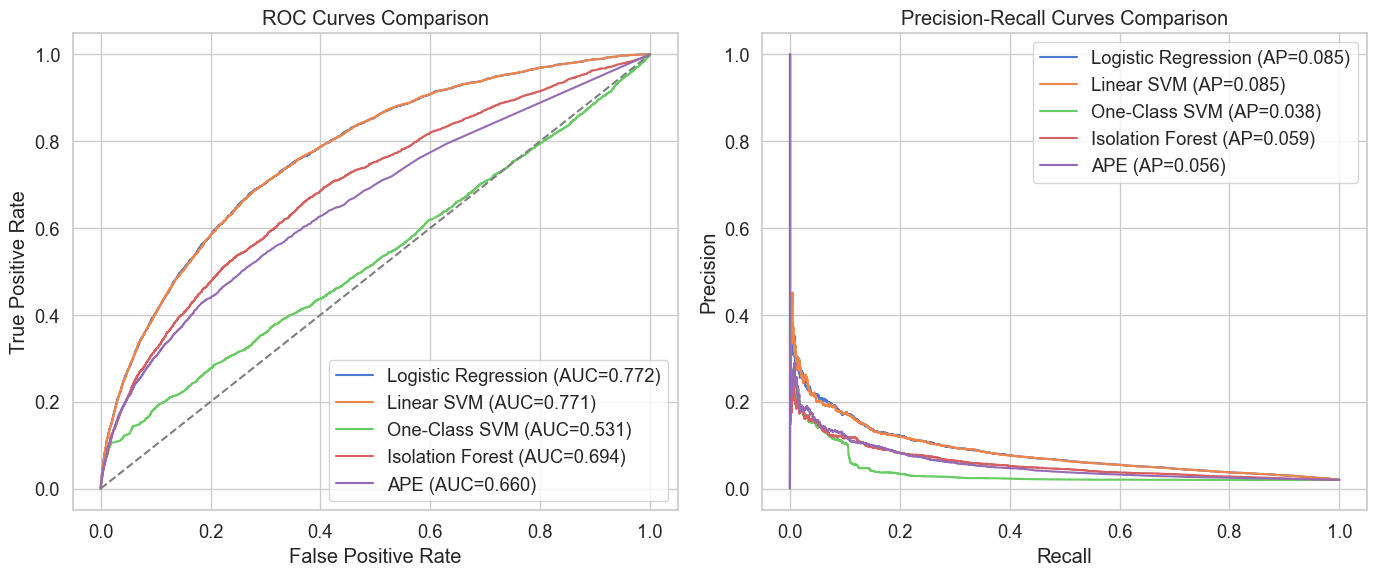

In [41]:
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curves
for name, y_score in scores.items():
    if name == 'APE':
        fpr, tpr, _ = roc_curve(y_test_ape, y_score, pos_label=-1)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')
ax_roc.plot([0, 1], [0, 1], '--', color='grey')
ax_roc.set_title('ROC Curves Comparison')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend(loc='lower right')

# Precision-Recall Curves
for name, y_score in scores.items():
    if name == 'APE':
        precision, recall, _ = precision_recall_curve(y_test_ape, y_score, pos_label=-1)
        ap = average_precision_score(y_test_ape, y_score, pos_label=-1)
    else:
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
    ax_pr.plot(recall, precision, label=f'{name} (AP={ap:.3f})')
ax_pr.set_title('Precision-Recall Curves Comparison')
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Phase 3.1 - Hybrid Modelling with Anomaly-Based Features

In this part of the notebook, a hybrid modelling strategy is explored in which traditional supervised classifiers are extended with anomaly scores as additional input features. These scores are generated using One Class models trained in phase 1.

The goal is to evaluate whether combining standard features with anomaly scores can improve performance.

Logistic Regression and Linear SVM are used as the base classifiers, and performance is assessed using ROC and Precision Recall curves.


In [42]:
# Load One Class models trained
ocsvm_path = 'oneclass_svm_cat.joblib'
iso_path   = 'isolation_forest_cat.joblib'
ape_path   = 'ape_cat.joblib'

if not all(os.path.exists(p) for p in [ocsvm_path, iso_path, ape_path]):
    raise FileNotFoundError("One or more One-Class model files are missing.")

In [43]:
ocsvm = load(ocsvm_path)
iso   = load(iso_path)
ape   = load(ape_path)

In [44]:
# Generate anomaly based features
scores_ocsvm_train = -ocsvm.decision_function(X_train_final_df)
scores_iso_train   = -iso.decision_function(X_train_final_df)
scores_ape_train   = ape.score_samples(X_train_final_df)

scores_ocsvm_test = -ocsvm.decision_function(X_test_final_df)
scores_iso_test   = -iso.decision_function(X_test_final_df)
scores_ape_test   = ape.score_samples(X_test_final_df)

In [45]:
# Add anomaly scores to training and test sets
X_train_stack = X_train_final_df.copy()
X_train_stack['score_ocsvm'] = scores_ocsvm_train
X_train_stack['score_iso']   = scores_iso_train
X_train_stack['score_ape']   = scores_ape_train

X_test_stack = X_test_final_df.copy()
X_test_stack['score_ocsvm'] = scores_ocsvm_test
X_test_stack['score_iso']   = scores_iso_test
X_test_stack['score_ape']   = scores_ape_test

In [46]:
# Train or Load Hybrid Models
LR_STACK_PATH  = "lr_stack_model_cat.joblib"
SVC_STACK_PATH = "svc_stack_model_cat.joblib"

if os.path.exists(LR_STACK_PATH):
    print("Loading existing stacked Logistic Regression model")
    lr_stack = load(LR_STACK_PATH)
else:
    print("Training Logistic Regression stacked model")
    lr_stack = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
    lr_stack.fit(X_train_stack, y_train)
    dump(lr_stack, LR_STACK_PATH)
    print(f"LR model saved to '{LR_STACK_PATH}'")

if os.path.exists(SVC_STACK_PATH):
    print("Loading existing stacked Linear SVM model")
    svc_stack = load(SVC_STACK_PATH)
else:
    print("Training Linear SVM stacked model")
    base_svc_stack = LinearSVC(max_iter=5000, class_weight='balanced', dual=False, random_state=42)
    base_svc_stack.fit(X_train_stack, y_train)
    svc_stack = CalibratedClassifierCV(estimator=base_svc_stack, method='sigmoid', cv=5)
    svc_stack.fit(X_train_stack, y_train)
    dump(svc_stack, SVC_STACK_PATH)
    print(f"Linear SVM saved to '{SVC_STACK_PATH}'")

Loading existing stacked Logistic Regression model
Loading existing stacked Linear SVM model


In [47]:
# Evaluate on test
y_lr_proba  = lr_stack.predict_proba(X_test_stack)[:, 1]
y_svc_proba = svc_stack.predict_proba(X_test_stack)[:, 1]

lr_auc  = roc_auc_score(y_test, y_lr_proba)
lr_ap   = average_precision_score(y_test, y_lr_proba)
svc_auc = roc_auc_score(y_test, y_svc_proba)
svc_ap  = average_precision_score(y_test, y_svc_proba)

In [48]:
print("\nTest set performance with anomaly scores:")
print(f"Logistic Regression + anomaly scores → AUC: {lr_auc:.3f}, AP: {lr_ap:.3f}")
print(f"Linear SVM + anomaly scores → AUC: {svc_auc:.3f}, AP: {svc_ap:.3f}")


Test set performance with anomaly scores:
Logistic Regression + anomaly scores → AUC: 0.773, AP: 0.084
Linear SVM + anomaly scores → AUC: 0.772, AP: 0.083


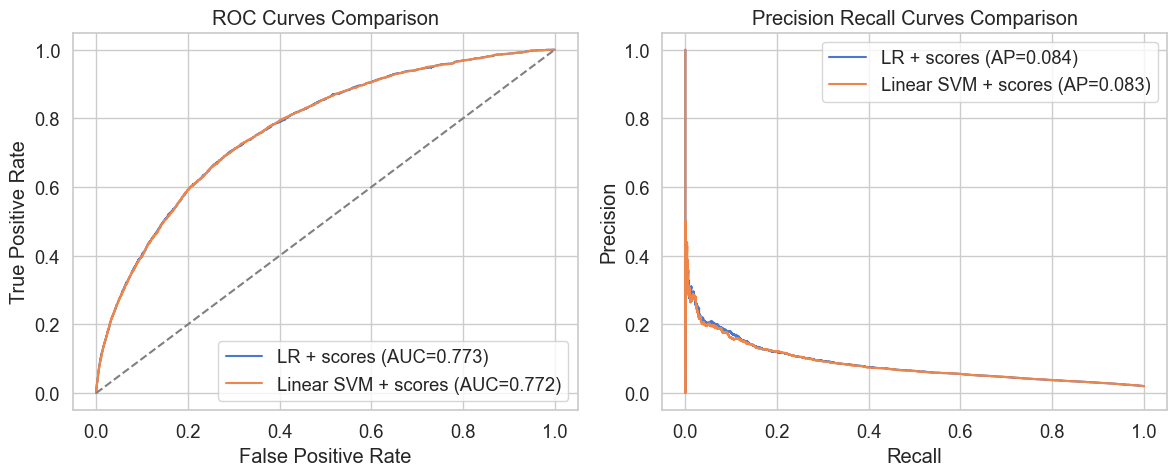

In [49]:
# Plot ROC and Precision-Recall Curves
fpr_lr, tpr_lr, _     = roc_curve(y_test, y_lr_proba)
prec_lr, rec_lr, _    = precision_recall_curve(y_test, y_lr_proba)
fpr_svc, tpr_svc, _   = roc_curve(y_test, y_svc_proba)
prec_svc, rec_svc, _  = precision_recall_curve(y_test, y_svc_proba)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f'LR + scores (AUC={lr_auc:.3f})')
plt.plot(fpr_svc, tpr_svc, label=f'Linear SVM + scores (AUC={svc_auc:.3f})')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# PR
plt.subplot(1, 2, 2)
plt.plot(rec_lr, prec_lr, label=f'LR + scores (AP={lr_ap:.3f})')
plt.plot(rec_svc, prec_svc, label=f'Linear SVM + scores (AP={svc_ap:.3f})')
plt.title('Precision Recall Curves Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()